In [1]:
%matplotlib inline
import sys, os
import numpy as np
import pandas as pd
import json
import seaborn as sns
from matplotlib import pyplot as plt

sys.path.append("../../../")

from cropseq import cfg


How to evaluate if the generated model fits well to the existing sequences in the dataset.

1. Generate sequences with the model and check if the output distribution is equivalent to the original dataset distribution. Basically we are comparing histograms here, so we can use correlation, chi-square or other distance d(H1, H2).
2. Likelihood of test data: put some of the data aside as test data and calculate the probability of these samples using forward algorithm. We can add up the log-prob of the tests samples and use this modelo as good-ness of fit.
3. Predict parts fot the data: usan the n-1 values of the sequences to estimate the nest most probable value and use it as model prediction, the use this prediction as input for a classification metric, ex f1-score.


Markov models typically are ment to solve three type of problems:
* Type 1: given an observation sequence O<sub>1</sub>, O<sub>2</sub>, ...O<sub>n</sub> compute the probability of the sequence for the model M.
* Type 2: given an observation sequence O<sub>1</sub>, O<sub>2</sub>, ...O<sub>n</sub> determine the best hidden state sequence to obtain the observed values.
* Type 3: given an observation sequence O<sub>1</sub>, O<sub>2</sub>, ...O<sub>n</sub>, estimate the model parameters to obtain M.

In this project we are trying to fit the model with unknown parameters, Type 3, but this process, given the stochastic nature of HMM, and the need to set a number of components beforehand, has to be iterative. For each possible number of components (hidden states) that we want to try, we have tu run the fit multiple times and register a good-of-fitness metric, to make sure that the model reached a possible best fit.



This problem is treated in [14]. There, the estimator proposed is
based on the entropy for a stationary stochastic process. A function of the model
entropy is selected and evaluated for different values of N. The smallest value
of N is chosen such that, by increasing N, no significant improvement in the
function value is observed.


In [2]:
history_file = cfg.results("history_full.json")
history_data = json.load(open(history_file, "r"))

Plot metrics vs number of states


<AxesSubplot:xlabel='n_states', ylabel='chi'>

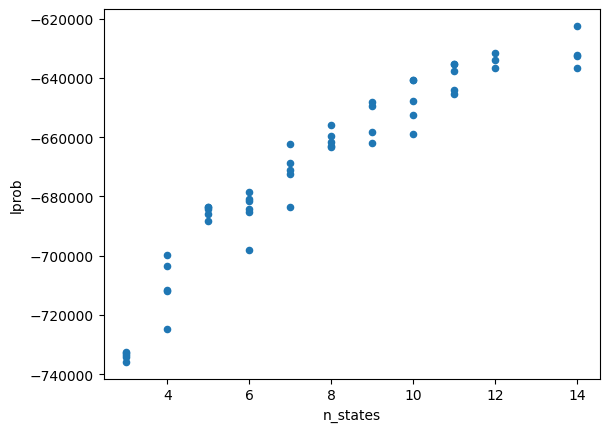

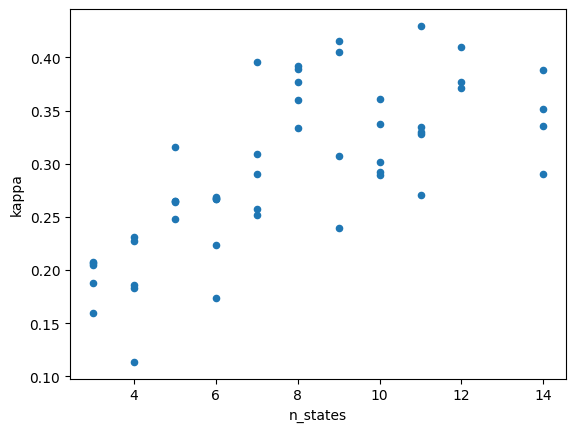

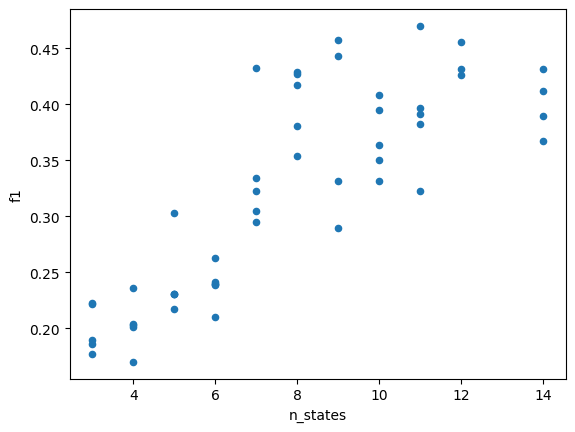

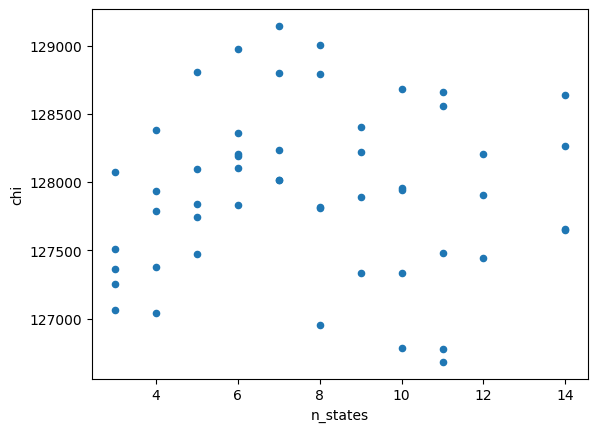

In [3]:
print("Plot metrics vs number of states")

# create dataset
df = pd.DataFrame(history_data)
df.plot(x="n_states", y="lprob", kind = "scatter")
df.plot(x="n_states", y="kappa", kind = "scatter")
df.plot(x="n_states", y="f1", kind = "scatter")
df.plot(x="n_states", y="chi", kind = "scatter")

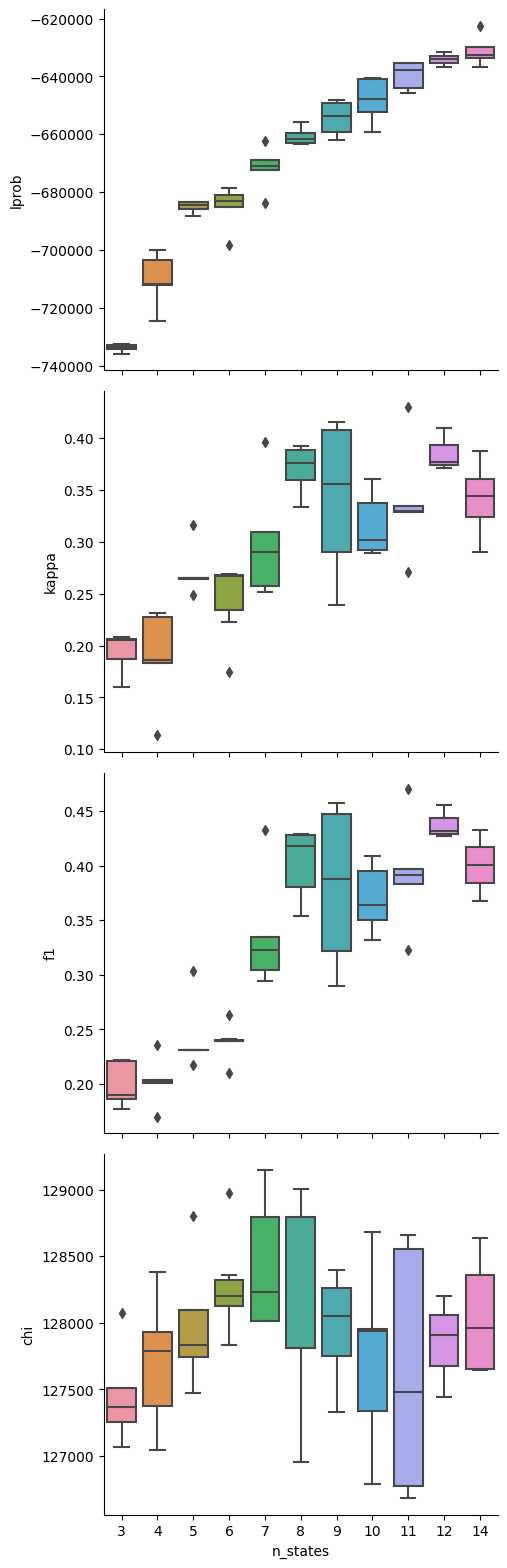

In [4]:
g = sns.PairGrid(data= df, x_vars=["n_states"], y_vars =["lprob", "kappa", "f1", "chi"], aspect=1.2, height=4)
x = g.map(sns.boxplot)

# sns.boxplot(data=df, x="n_states", y="lprob")
# sns.boxplot(data=df, x="n_states", y="kappa")
# sns.boxplot(data=df, x="n_states", y="f1")
# sns.boxplot(data=df, x="n_states", y="chi")

Conclusions about the charts:
- The -log(prob) increases as the number of states goes up, this means as the number of hidden states increases, the model is capable of fitting to de sequences represented in the dataset. 
- Increasing the number of states without limit, even while the -log(prob) improves, can lead to overfitting, so and additional metric that takes into account the good-of-fitnesss over the test dataset must be included to avoid this overfitting.
- F1 and Kappa scores are measured over the test split, these metrics improve up to the n_state=12 value.
- Chi<sup>2</sup> measures the similarity between the original dataset distribution and the distribution generated by the HMM model (events distribution). In this case the results aren't clear, the number of samples generated by the model is the same as the train split size, the number of bins is 20, is it possible that using the same number of bins as possible values in the categories.

Finally a model is trained using n_states = 12, the model has been trained using 50% of the available data for performance reasons.

In [5]:
import pickle

model_file = '/media/gus/workspace/wml/crop_hist_detector/results/hmm_granade.pickle'

hmm_model = pickle.load(file=open(model_file, 'rb'))

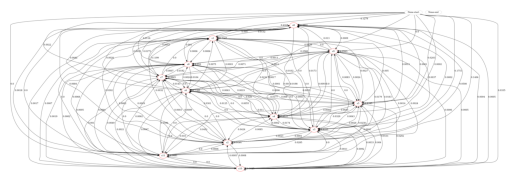

In [6]:
hmm_model.plot()